<a href="https://colab.research.google.com/github/elpinchepastel/Hyperspectral-Remote-Sensing-Scenes/blob/master/Salinas%20Correct%20%2B%20SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Hyperspectral Image Classify**

This project is structured so:

1. Import necessary libraries

2. Download dataset Salinas (Correct and gt)

3. Review of dataset structure and loading

4. Visualizing ground truth

5. Visualizing the bands of the Correct

6. Extract pixels and class from the dataset, preparing the data for reduction

7. Classify Salinas Correct by support vector machine (SVM)

## **1. Import necessary libraries**

In [1]:
%%time
!pip install spectral
!pip install tqdm

CPU times: user 17.7 ms, sys: 9.45 ms, total: 27.2 ms
Wall time: 4.24 s


In [2]:
import joblib
import numpy as np
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import pandas as pd
import random
import scipy.io
import scipy.io as sio
import seaborn as sns
import spectral

from IPython.display import Image
from matplotlib.legend_handler import HandlerLine2D
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.io import loadmat
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import metrics
from sklearn.svm import SVC
from tqdm import tqdm

sns.axes_style('whitegrid');

# **2. Download dataset Salinas (Correct and gt)**

In [3]:
%%time
!wget "http://www.ehu.eus/ccwintco/uploads/a/a3/Salinas_corrected.mat"
!wget "http://www.ehu.eus/ccwintco/uploads/f/fa/Salinas_gt.mat"

--2020-10-19 06:40:50--  http://www.ehu.eus/ccwintco/uploads/a/a3/Salinas_corrected.mat
Resolving www.ehu.eus (www.ehu.eus)... 158.227.0.65, 2001:720:1410::65
Connecting to www.ehu.eus (www.ehu.eus)|158.227.0.65|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 26552770 (25M) [text/plain]
Saving to: ‘Salinas_corrected.mat’

Salinas_corrected.m 100%[===================>]  25.32M  2.24MB/s    in 13s     

2020-10-19 06:41:03 (1.92 MB/s) - ‘Salinas_corrected.mat’ saved [26552770/26552770]

--2020-10-19 06:41:03--  http://www.ehu.eus/ccwintco/uploads/f/fa/Salinas_gt.mat
Resolving www.ehu.eus (www.ehu.eus)... 158.227.0.65, 2001:720:1410::65
Connecting to www.ehu.eus (www.ehu.eus)|158.227.0.65|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4277 (4.2K) [text/plain]
Saving to: ‘Salinas_gt.mat’

Salinas_gt.mat      100%[===================>]   4.18K  --.-KB/s    in 0s      

2020-10-19 06:41:03 (552 MB/s) - ‘Salinas_gt.mat’ saved [4277/4277]

CPU

In [4]:
# Verify that the ".mat" type dataset is downloaded locally
!ls

Salinas_corrected.mat  Salinas_gt.mat  sample_data


## **3. Review of dataset structure and loading**

In [5]:
# Data types for the dataset
correct = loadmat('Salinas_corrected.mat')
gt = loadmat('Salinas_gt.mat')
print(type(correct))
print(type(gt))

<class 'dict'>
<class 'dict'>


In [6]:
# The keys of the dictionary
print(f'Dictionary Salinas Correct: {correct.keys()}\nDictionary Salinas Ground truth: {gt.keys()}')

Dictionary Salinas Correct: dict_keys(['__header__', '__version__', '__globals__', 'salinas_corrected'])
Dictionary Salinas Ground truth: dict_keys(['__header__', '__version__', '__globals__', 'salinas_gt'])


In [7]:
# Read the dataset
def dataset(correct, gt):
  dataset_correct = scipy.io.loadmat('Salinas_corrected.mat')['salinas_corrected']
  dataset_gt = scipy.io.loadmat('Salinas_gt.mat')['salinas_gt']
  return dataset_correct, dataset_gt

In [8]:
dataset_correct, dataset_gt = dataset(correct, gt)
print(f'Correct: {dataset_correct.shape}\nGround Truth: {dataset_gt.shape}')

Correct: (512, 217, 204)
Ground Truth: (512, 217)


In [9]:
print(type(dataset_correct))
print(type(dataset_gt))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [10]:
# Number of each category
dict_category = {}
for i in range(dataset_gt.shape[0]):
    for j in range(dataset_gt.shape[1]):
         if dataset_gt[i][j] in [0,1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]:
            if dataset_gt[i][j] not in dict_category:
                dict_category[dataset_gt[i][j]]=0
            dict_category[dataset_gt[i][j]] +=1
            
sortedDict = sorted(dict_category.items())
print(sortedDict)

[(0, 56975), (1, 2009), (2, 3726), (3, 1976), (4, 1394), (5, 2678), (6, 3959), (7, 3579), (8, 11271), (9, 6203), (10, 3278), (11, 1068), (12, 1927), (13, 916), (14, 1070), (15, 7268), (16, 1807)]


## **4. Visualizing ground truth**

In [11]:
# Colors and names for each category in the dataset
def colors_names():
  gt_color = np.array([
                      [255,   255,    255], #Backgroud
                      [0,     0,      255], #Brocoli_green_weeds_1
                      [0,     64,     255], #Brocoli_green_weeds_2
                      [0,     128,    255], #Fallow
                      [0,     191,    255], #Fallow_rough_plow
                      [0,     255,    255], #Fallow_smooth
                      [0  ,   255,    191], #Stubble
                      [64,    255,    191], #Celery
                      [128,   255,    128], #Grapes_untrained
                      [191,   255,    64],  #Soil_vinyard_develop
                      [255,   255,    0],   #Corn_senesced_green_weeds
                      [255,   191,    0],   #Lettuce_romaine_4wk
                      [255,   128,    0],   #Lettuce_romaine_5wk
                      [255,   64,     0],   #Lettuce_romaine_6wk
                      [255,   0,      0],   #Lettuce_romaine_7wk
                      [191,   0,      0],   #Vinyard_untrained
                      [128,   0,      0],   #Vinyard_vertical_trellis
                       ])
  salinas_class_names = [
                            'Background',
                            'Brocoli_green_weeds_1',
                            'Brocoli_green_weeds_2',
                            'Fallow',
                            'Fallow_rough_plow',
                            'Fallow_smooth',
                            'Stubble',
                            'Celery',
                            'Grapes_untrained',
                            'Soil_vinyard_develop',
                            'Corn_senesced_green_weeds',
                            'Lettuce_romaine_4wk',
                            'Lettuce_romaine_5wk',
                            'Lettuce_romaine_6wk',
                            'Lettuce_romaine_7wk',
                            'Vinyard_untrained',
                            'Vinyard_vertical_trellis'
                            ]
  gt_color_eventplot = gt_color/255
  return gt_color, gt_color_eventplot, salinas_class_names

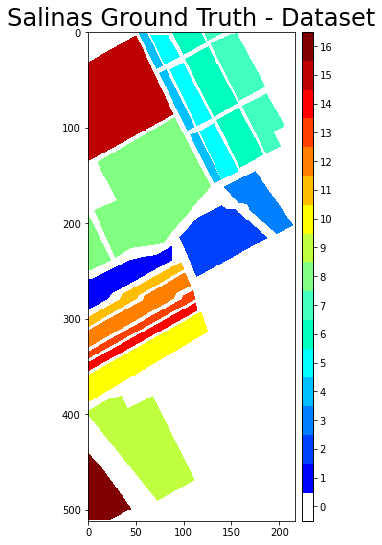

In [12]:
# Display of the "Ground truth" image
gt_color, gt_color_eventplot, salinas_class_names = colors_names()
ground_truth = spectral.imshow(classes = dataset_gt.astype(int), figsize =(9, 9),colors=gt_color, interpolation='nearest')
plt.title('Salinas Ground Truth - Dataset', fontsize=24)
#plt.xticks([])
#plt.yticks([])
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
plt.colorbar(cax=cax)
plt.colorbar(ticks= range(0,17), cax=cax)
plt.savefig('Salinas Ground Truth.TIF')

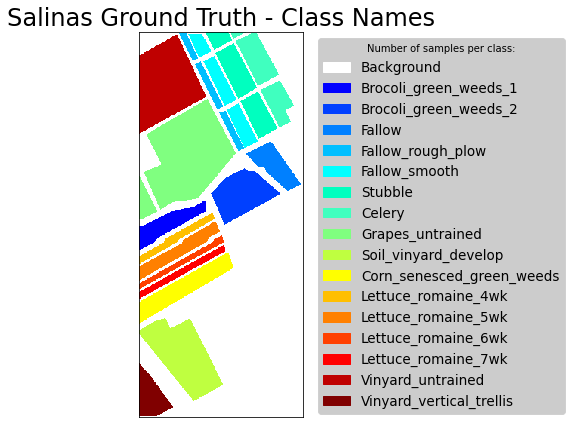

In [13]:
ground_truth = spectral.imshow(classes = dataset_gt.astype(int), figsize =(6, 9),colors=gt_color, interpolation='nearest')
plt.title('Salinas Ground Truth - Class Names', fontsize=24)
patches = [mpatches.Patch(color=gt_color_eventplot[i], label=salinas_class_names[i]) for i in range(len(gt_color_eventplot))]
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1.0), loc='upper left', facecolor='silver', fontsize=13.5, title="Number of samples per class:")
plt.tight_layout()
plt.xticks([])
plt.yticks([])
plt.savefig('Samples and number Salinas Ground Truth.TIF')

## **5. Visualizing the bands of the Hyperspectral Correct**

Enter the band number of the image you want to view (The number to be between 0 and 203): 
10


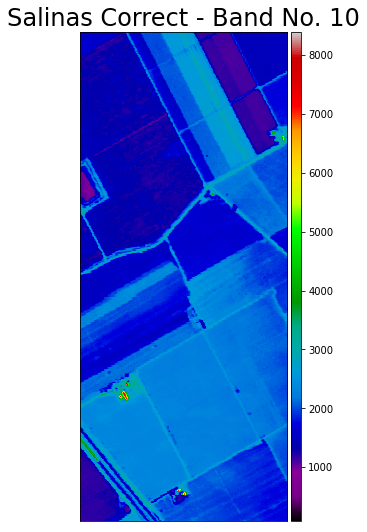

In [14]:
# Display of the "Correct" image on one band

print('Enter the band number of the image you want to view (The number to be between 0 and 203): ')
band = int(input())
one_band = dataset_correct[:, :, band]
plt.figure(figsize=(9, 9))
plt.imshow(one_band, cmap = "nipy_spectral")
plt.title(f'Salinas Correct - Band No. {band}', fontsize=24)
plt.xticks([])
plt.yticks([])
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(cax=cax)
plt.savefig(f'Salinas Correct - Band No. {band}.TIF')

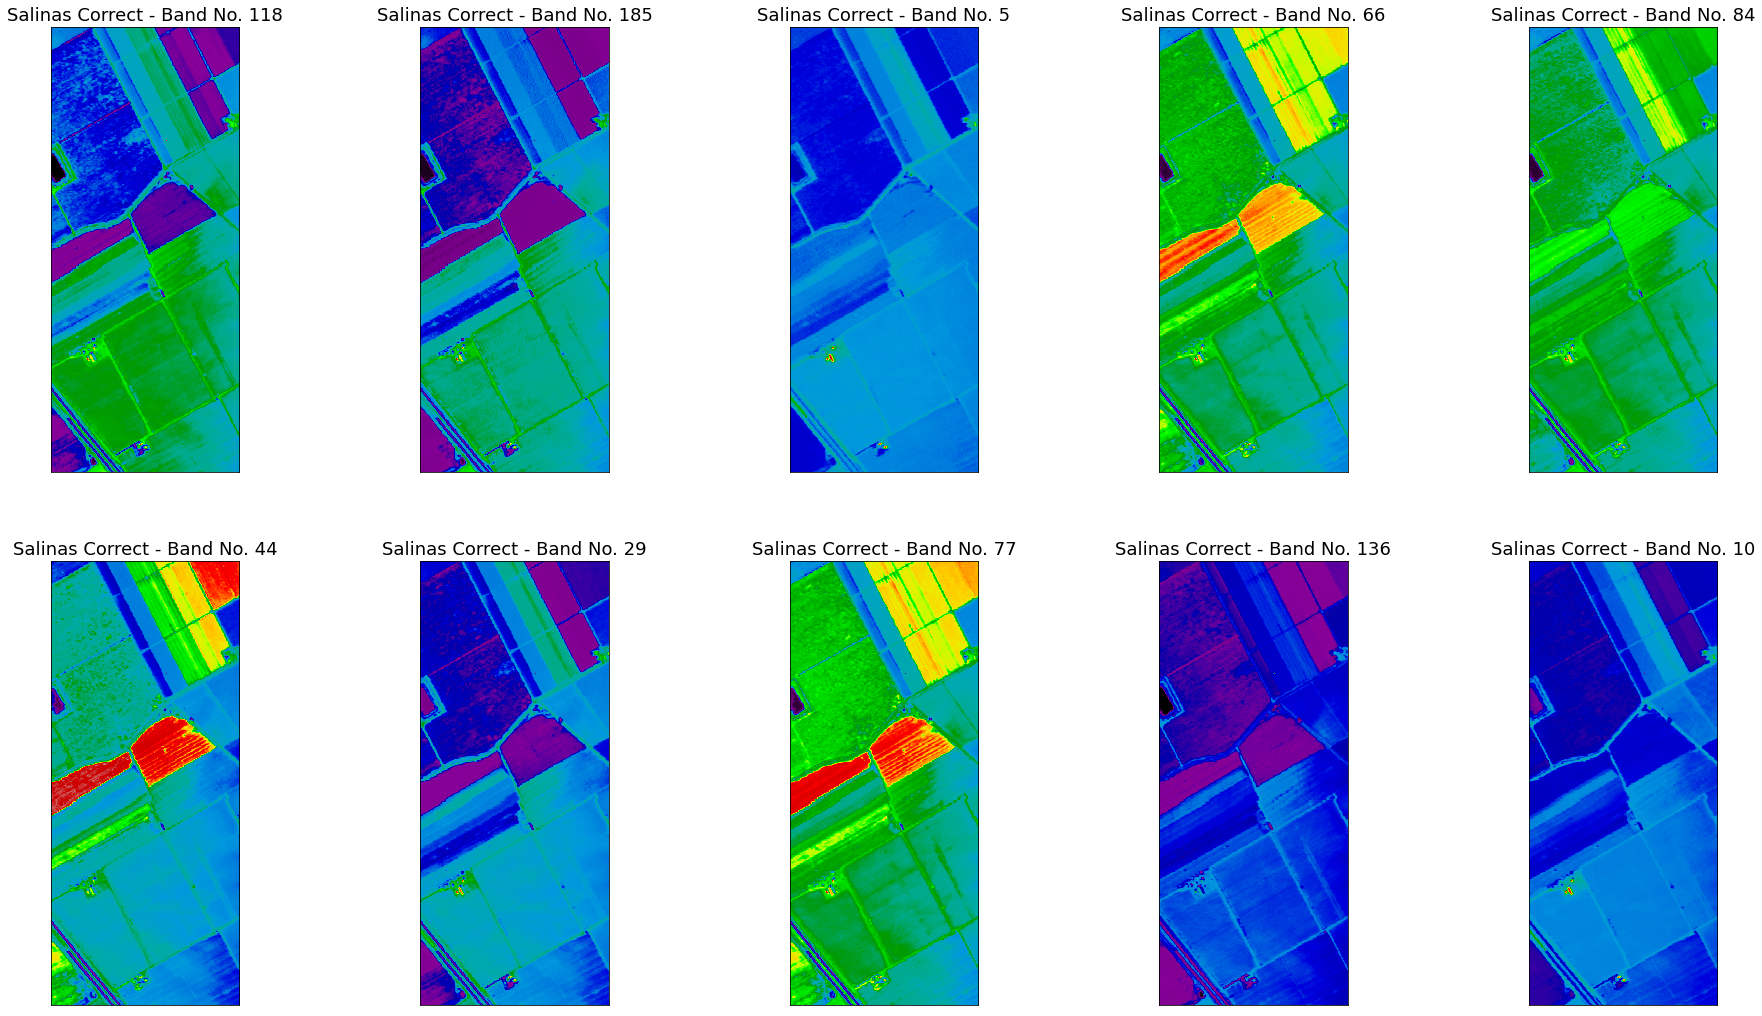

In [15]:
# Display of the "Correct" image on one band random
fig=plt.figure(figsize=(32, 18))
columns = 5
rows = 2
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    band_aleatory = random.randrange(203)
    one_band = dataset_correct[:, :, band_aleatory]
    plt.imshow(one_band, cmap = "nipy_spectral")
    plt.title(f'Salinas Correct - Band No. {band_aleatory}', fontsize=18)
    plt.xticks([])
    plt.yticks([])
plt.savefig('Salinas Correct - Teen Band Aleatory.TIF')

## **6.  Extract pixels and class from the dataset, preparing the data for reduction**

In [16]:
# Refactoring classes
dataset_correct, dataset_gt = dataset(correct, gt)
need_label = np.zeros([dataset_gt.shape[0],dataset_gt.shape[1]])
for i in range(dataset_gt.shape[0]):
    for j in range(dataset_gt.shape[1]):
        if dataset_gt[i][j] != 0:
            need_label[i][j] = dataset_gt[i][j]
        
            
new_datawithlabel_list = []
for i in range(dataset_gt.shape[0]):
    for j in range(dataset_gt.shape[1]):
        if need_label[i][j] != 0:
            c2l = list(dataset_correct[i][j])
            c2l.append(need_label[i][j])
            new_datawithlabel_list.append(c2l)

new_datawithlabel_array = np.array(new_datawithlabel_list)

In [17]:
# Standardize data and store in a CSV file
data_D = preprocessing.StandardScaler().fit_transform(new_datawithlabel_array[:,:-1])
data_L = new_datawithlabel_array[:,-1]
new = np.column_stack((data_D,data_L))
new_ = pd.DataFrame(new)
new_.to_csv('correct.csv',header=False,index=False)

## **7. Classify Salinas Correct by support vector machine (SVM)**


In [18]:
# Train the model and store the model
data = pd.read_csv('correct.csv',header=None)
data = data.values
data_D = data[:,:-1]
data_L = data[:,-1]
data_train, data_test, label_train, label_test = train_test_split(data_D,data_L,test_size=0.20, random_state = 11)

clf = SVC(kernel='rbf', degree = 10, gamma='scale', cache_size=1024*7)
clf.fit(data_train,label_train)
pred = clf.predict(data_test)
accuracy = metrics.accuracy_score(label_test, pred)*100
print(accuracy,"%")

joblib.dump(clf, "correct_model.m")

91.49270275263255 %


['correct_model.m']

In [19]:
dataset_correct, dataset_gt = dataset(correct, gt)
input_image = dataset_correct
output_image = dataset_gt

testdata = np.genfromtxt('correct.csv',delimiter=',')
data_test = testdata[:,:-1]
label_test = testdata[:,-1]

clf = joblib.load("correct_model.m")

predict_label = clf.predict(data_test)
accuracy = metrics.accuracy_score(label_test, predict_label)*100

print(accuracy, "%")

91.58491751186979 %


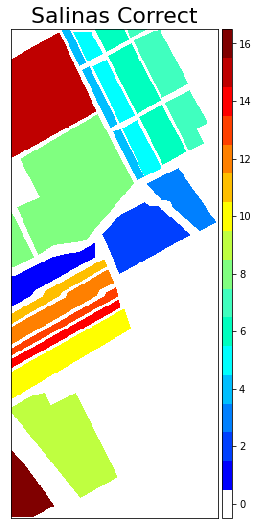

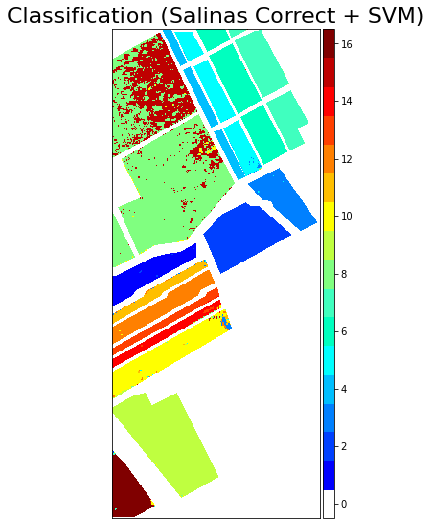

In [20]:
# Displaying the "Salinas Correct" and SVM
new_show = np.zeros((output_image.shape[0],output_image.shape[1]))
k = 0
for i in range(output_image.shape[0]):
    for j in range(output_image.shape[1]):
        if output_image[i][j] != 0 :
            new_show[i][j] = predict_label[k]
            k +=1 

gt_color, gt_color_eventplot, salinas_class_names = colors_names()
dataset_correct, dataset_gt = dataset(correct, gt)
dataset_gt = spectral.imshow(classes = dataset_gt.astype(int), figsize =(9,9),colors=gt_color, interpolation='nearest')
plt.xticks([])
plt.yticks([])
plt.title('Salinas Correct', fontsize=22)
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(cax=cax)

dataset_correct_svm = spectral.imshow(classes = new_show.astype(int), figsize =(9,9),colors=gt_color, interpolation='nearest')
plt.xticks([])
plt.yticks([])
plt.title('Classification (Salinas Correct + SVM)', fontsize=22)
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(cax=cax)

plt.savefig('Salinas Correct and SVM.TIF')